In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500

import warnings
warnings.filterwarnings('ignore')

# Get Data

In [2]:
animalDf = pd.read_csv("train a.csv", sep=",")
animalDf.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


In [3]:
animalDf.drop(['Name', 'AnimalID', 'OutcomeSubtype'], axis=1, inplace=True)

In [4]:
myData = animalDf

m = []
countData = len(myData)

for i in range(len(myData.columns)):
    countNull = len(myData[myData[myData.columns[i]].isnull()])
    nullPct = countNull/countData * 100
    
    sample = []
    
    for item, x in zip(myData[myData.columns[i]].drop_duplicates(), range(5)):
        sample.append(item)
    
    m.append([
        myData.columns[i],
        myData[myData.columns[i]].dtypes, 
        countNull, 
        nullPct, 
        myData[myData.columns[i]].nunique(), 
        sample
    ])
    
describeDF = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'], data=m)
describeDF

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,DateTime,object,0,0.000000,22918,"[2014-02-12 18:22:00, 2013-10-13 12:44:00, 2015-01-31 12:28:00, 2014-07-11 19:09:00, 2013-11-15 ..."
1,OutcomeType,object,0,0.000000,5,"[Return_to_owner, Euthanasia, Adoption, Transfer, Died]"
2,AnimalType,object,0,0.000000,2,"[Dog, Cat]"
3,SexuponOutcome,object,2,0.003741,5,"[Neutered Male, Spayed Female, Intact Male, Intact Female, Unknown]"
4,AgeuponOutcome,object,36,0.067343,44,"[1 year, 2 years, 3 weeks, 1 month, 5 months]"
5,Breed,object,0,0.000000,1380,"[Shetland Sheepdog Mix, Domestic Shorthair Mix, Pit Bull Mix, Lhasa Apso/Miniature Poodle, Cairn..."
6,Color,object,0,0.000000,366,"[Brown/White, Cream Tabby, Blue/White, Blue Cream, Tan]"


In [5]:
animalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53458 entries, 0 to 53457
Data columns (total 7 columns):
DateTime          53458 non-null object
OutcomeType       53458 non-null object
AnimalType        53458 non-null object
SexuponOutcome    53456 non-null object
AgeuponOutcome    53422 non-null object
Breed             53458 non-null object
Color             53458 non-null object
dtypes: object(7)
memory usage: 2.9+ MB


# EDA

## Feature Engineering

In [6]:
animalDf = animalDf.dropna()

In [7]:
animalDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53420 entries, 0 to 53457
Data columns (total 7 columns):
DateTime          53420 non-null object
OutcomeType       53420 non-null object
AnimalType        53420 non-null object
SexuponOutcome    53420 non-null object
AgeuponOutcome    53420 non-null object
Breed             53420 non-null object
Color             53420 non-null object
dtypes: object(7)
memory usage: 3.3+ MB


In [8]:
adoption = []

for item in animalDf['OutcomeType']:
    if (item=='Adoption'): 
        adoption.append(1)
    else:
        adoption.append(0)

animalDf = animalDf.assign(adoption=adoption)

In [9]:
animalDf = animalDf.assign(month=pd.DatetimeIndex(animalDf['DateTime']).month)

In [10]:
def setAges(age):
    age = age.split(' ')
    if ((age[1]=='year') | (age[1]=='years')):
        day = int(age[0])*365
    elif ((age[1]=='month') | (age[1]=='months')):
        day = int(age[0])*30
    elif ((age[1]=='week') | (age[1]=='weeks')):
        day = int(age[0])*7
    else:
        day = int(age[0])
        
    return day

animalDf = animalDf.assign(Ages=animalDf['AgeuponOutcome'].apply(lambda age: setAges(age)))
animalDf.drop('AgeuponOutcome', axis=1, inplace=True)

In [11]:
breed = []

for item in animalDf['Breed']:
    if 'Mix' in item.split(): 
        breed.append('mixed') 
    else:
        breed.append('pure') 
        
animalDf = animalDf.assign(nBreed=breed)

In [12]:
animalDf.head(2)

,DateTime,OutcomeType,AnimalType,SexuponOutcome,Breed,Color,adoption,month,Ages,nBreed
0,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,0,2,365,mixed
1,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,0,10,365,mixed


### 1. Perbandingan jumlah hewan (per bulan)

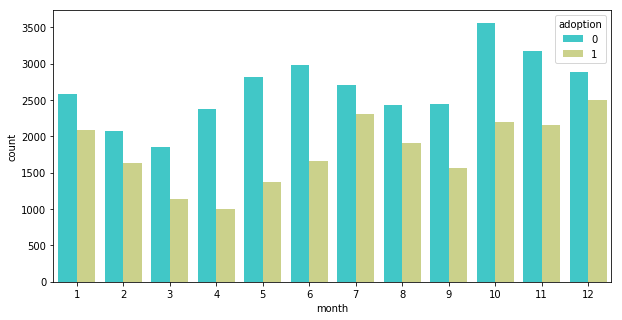

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x=animalDf['month'], data=animalDf, palette='rainbow', hue='adoption')

Kesimpulan: 
- Jumlah hewan yang tidak diadopsi lebih banyak dibandingkan dengan jumlah hewan yang diadopsi. 
- Hewan paling banyak diadopsi pada bulan Desember

### 2. Perbandingan adopsi per jenis hewan

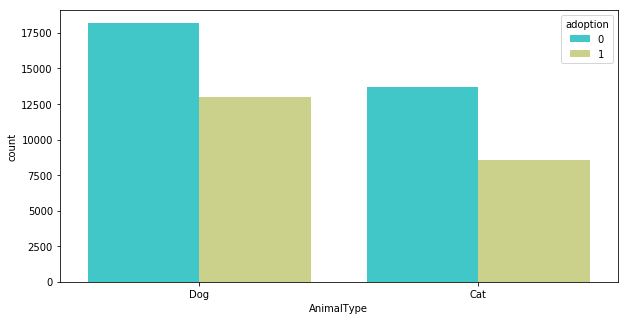

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(x='AnimalType', data=animalDf, palette='rainbow', hue='adoption')

Kesimpulan:
- Hewan dengan jumlah paling banyak, dan yang paling banyak diadopsi adalah anjing

### 3. Perbandingan adopsi per jenis kelamin

##### a. Perbandingan adopsi per jenis kelamin (keseluruhan)

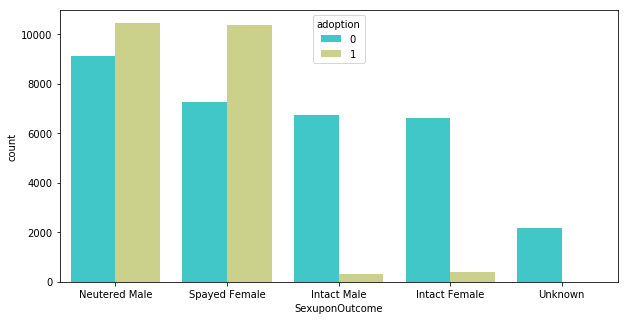

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(x='SexuponOutcome', data=animalDf, palette='rainbow', hue='adoption')

##### b. Perbandingan adopsi anjing per jenis kelamin

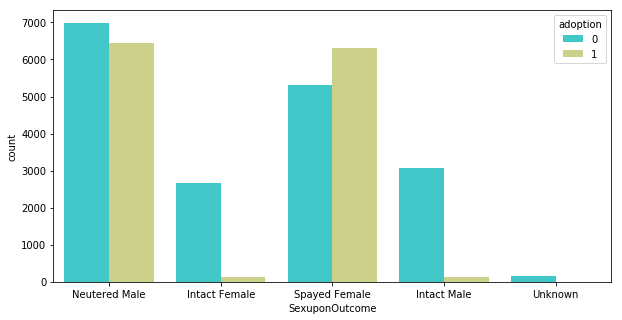

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x='SexuponOutcome', data=animalDf[(animalDf['AnimalType']=='Dog')], palette='rainbow', hue='adoption')

##### b. Perbandingan adopsi kucing per jenis kelamin

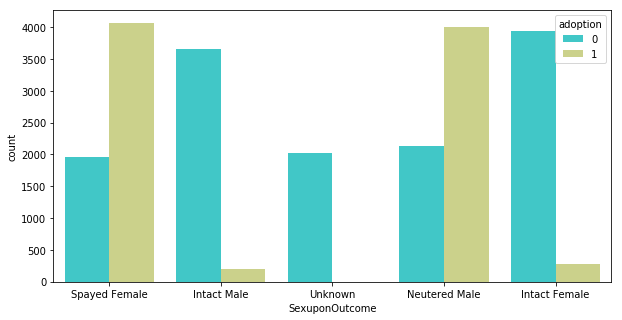

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x='SexuponOutcome', data=animalDf[(animalDf['AnimalType']=='Cat')], palette='rainbow', hue='adoption')

Kesimpulan:
- Hewan yang sudah disteril lebih banyak diadopsi (baik anjing maupun kucing)
- Hewan yang belum disteril cenderung tidak diadopsi
- Hewan yang tidak diketahui jenis kelaminnya tidak diadopsi

### 5. Perbandingan adopsi per jenis breed

##### a. Perbandingan adopsi per jenis breed (keseluruhan)

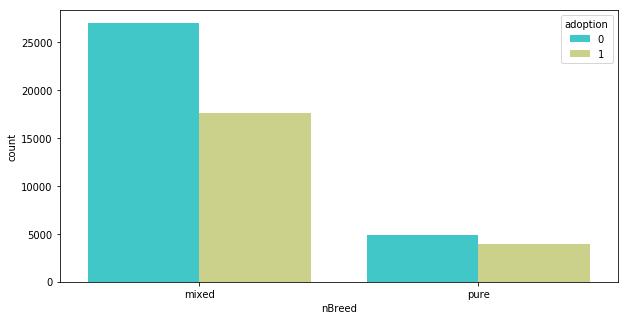

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x='nBreed', data=animalDf, palette='rainbow', hue='adoption')

##### b. Perbandingan adopsi anjing per jenis breed

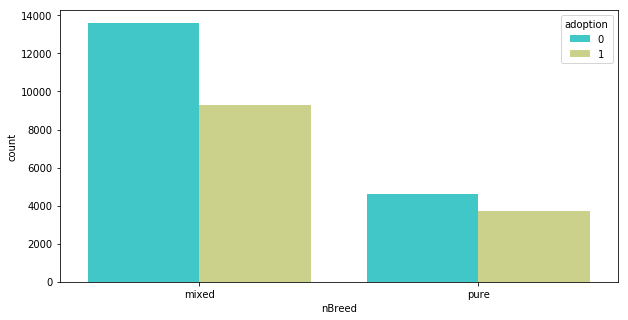

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(x='nBreed', data=animalDf[animalDf['AnimalType']=='Dog'], palette='rainbow', hue='adoption')

##### c. Perbandingan adopsi kucing per jenis breed

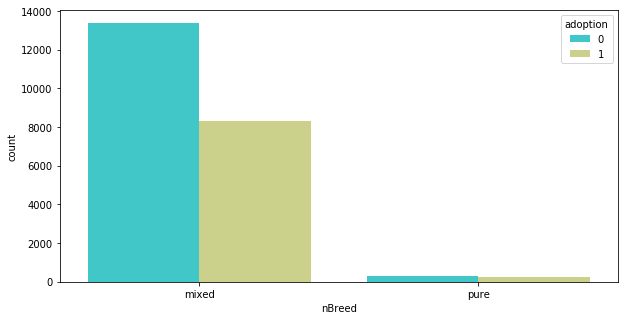

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x='nBreed', data=animalDf[animalDf['AnimalType']=='Cat'], palette='rainbow', hue='adoption')

Kesimpulan:
- Jumlah hewan keturunan campuran berjumlah lebih banyak dan diadopsi lebih banyak juga dibandingkan dengan hewan keturunan murni (kucing maupun anjing)

### 6. Breed anjing

##### a. 5 Breed anjing terbanyak

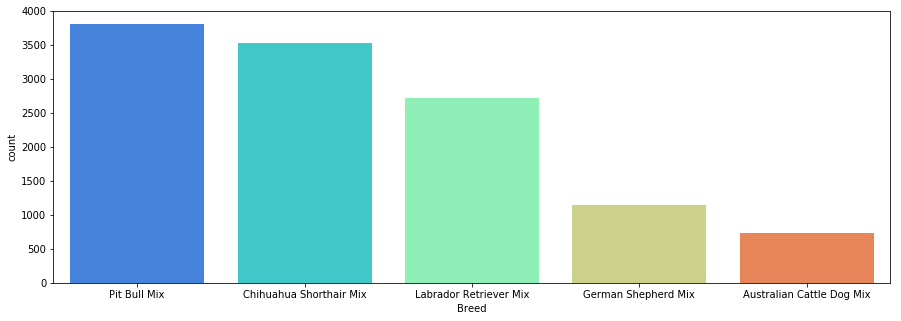

In [21]:
top5Dog = animalDf[animalDf['AnimalType']=='Dog'].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5Dog)) & (animalDf['AnimalType']=='Dog')], palette='rainbow', order=top5Dog)

##### b. 5 Breed anjing yang paling banyak diadopsi

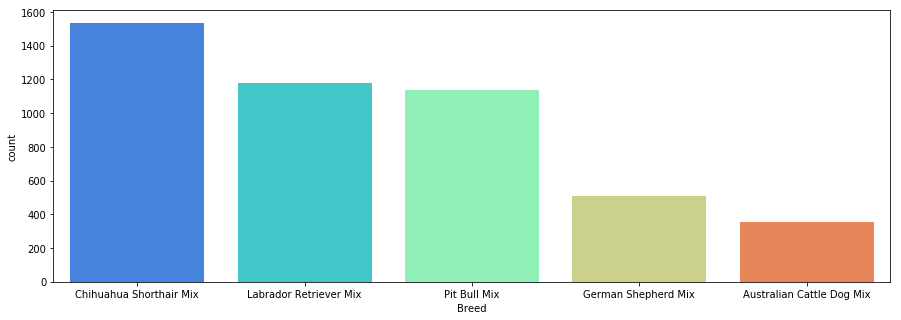

In [22]:
top5DogAdopt = animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==1)].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5DogAdopt)) & (animalDf['AnimalType']=='Dog') & (animalDf['adoption']==1)], palette='rainbow', order=top5DogAdopt)

##### c. 5 Breed anjing yang paling banyak tidak diadopsi

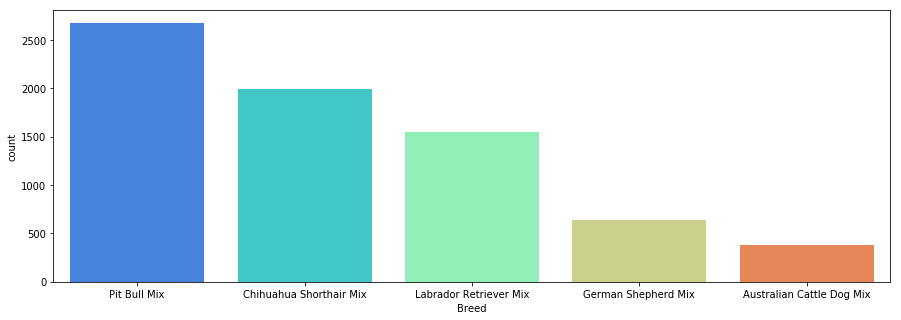

In [23]:
top5DogNotAdopt = animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==0)].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5DogNotAdopt)) & (animalDf['AnimalType']=='Dog') & (animalDf['adoption']==0)], palette='rainbow', order=top5DogNotAdopt)

### 7. Breed kucing

##### a. 5 Breed kucing terbanyak

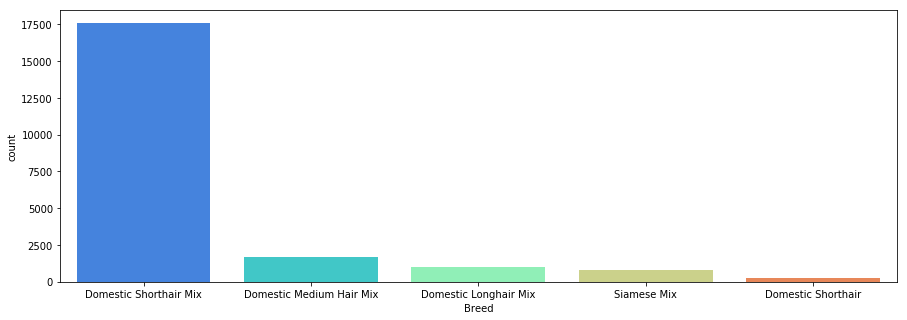

In [24]:
top5Cat = animalDf[animalDf['AnimalType']=='Cat'].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5Cat)) & (animalDf['AnimalType']=='Cat')], palette='rainbow', order=top5Cat)

##### b. 5 breed kucing yang paling banyak diadopsi

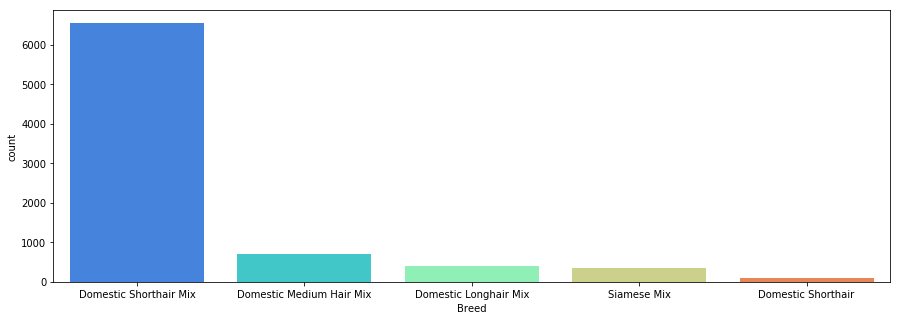

In [25]:
top5CatAdopt = animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==1)].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5CatAdopt)) & (animalDf['AnimalType']=='Cat') & (animalDf['adoption']==1)], palette='rainbow', order=top5CatAdopt)

##### c. 5 Breed kucing yang paling banyak tidak diadopsi

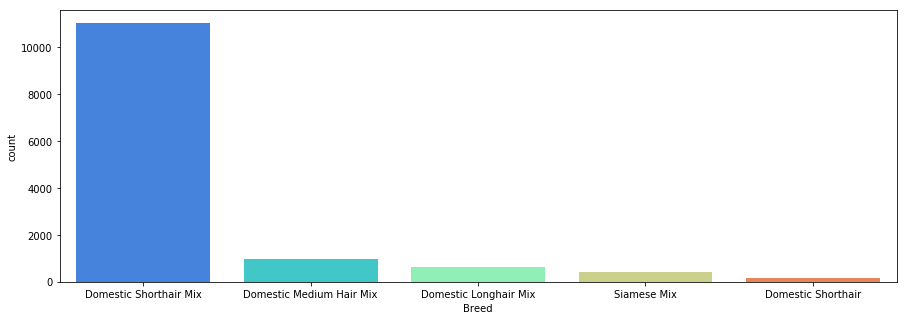

In [26]:
top5CatNotAdopt = animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==0)].groupby('Breed').count().sort_values('nBreed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Breed', data=animalDf[(animalDf['Breed'].isin(top5CatNotAdopt)) & (animalDf['AnimalType']=='Cat') & (animalDf['adoption']==0)], palette='rainbow', order=top5CatNotAdopt)

In [27]:
animalDf.drop('nBreed', axis=1, inplace=True)

### 6. Umur anjing (hitungan hari)

##### a. Perbandingan jumlah anjing per umur

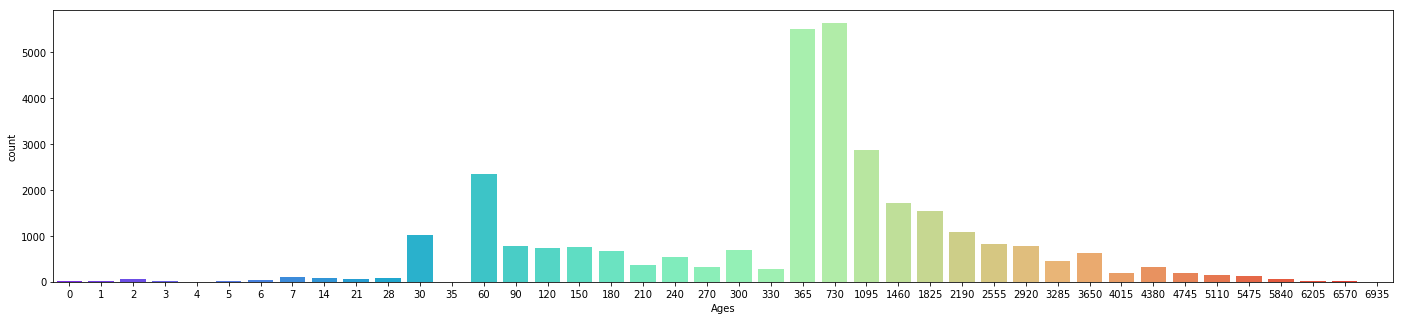

In [28]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[animalDf['AnimalType']=='Dog'], palette='rainbow')

##### b. Perbandingan jumlah anjing yang diadopsi per umur

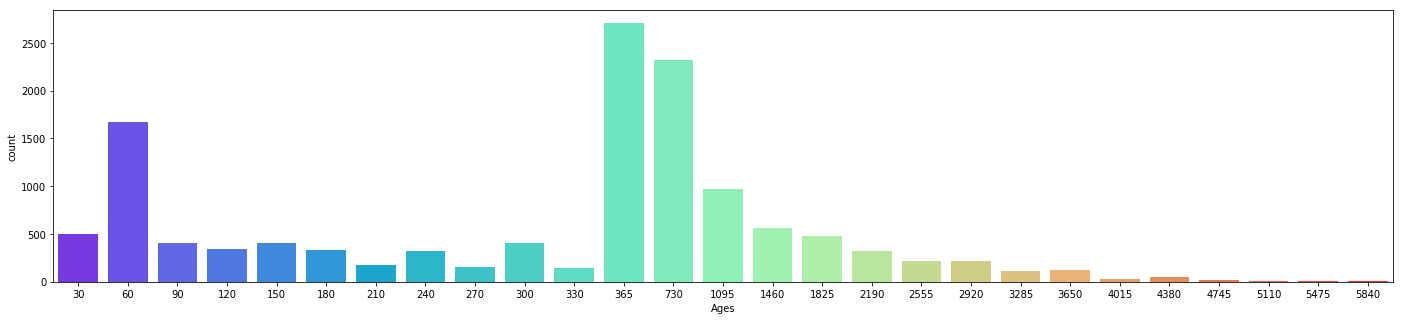

In [29]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==1)], palette='rainbow')

##### c. Perbandingan jumlah anjing yang tidak diadopsi per umur

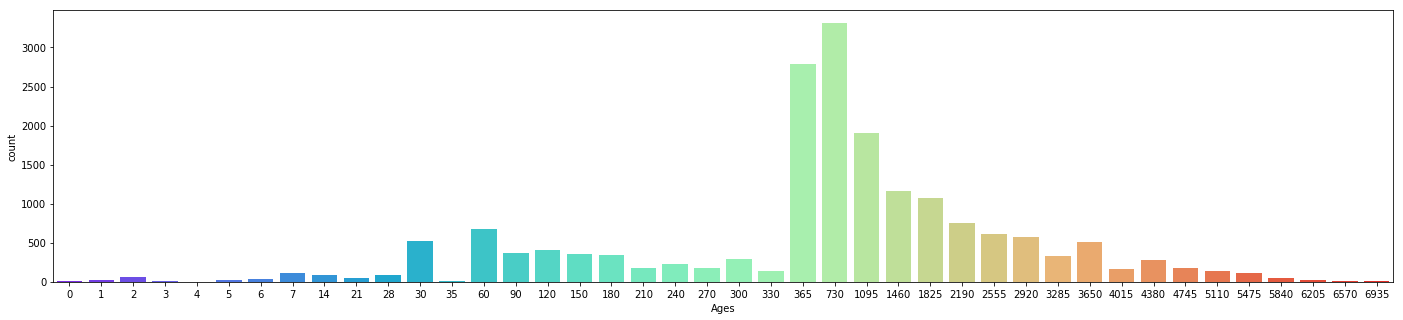

In [30]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==0)], palette='rainbow')

Kesimpulan:
- Range umur anjing dari umur 0 - 6935 hari
- Umur anjing paling banyak ada di range 365 - 1095 hari 
- Umur anjing yang paling banyak diadopsi: 60, 365, 730 hari

### 7. Umur kucing (hitungan hari)

##### a. Perbandingan jumlah kucing per umur

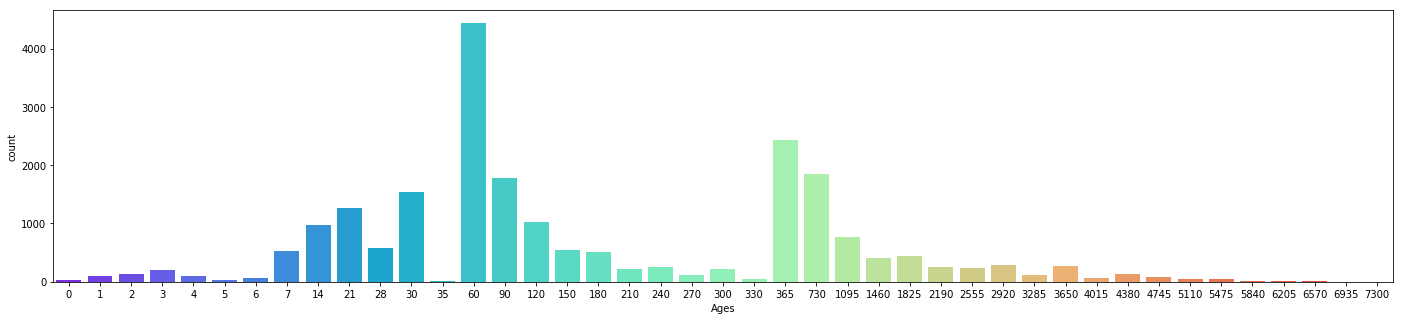

In [31]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[animalDf['AnimalType']=='Cat'], palette='rainbow')

##### b. Perbandingan jumlah kucing yang diadopsi per umur

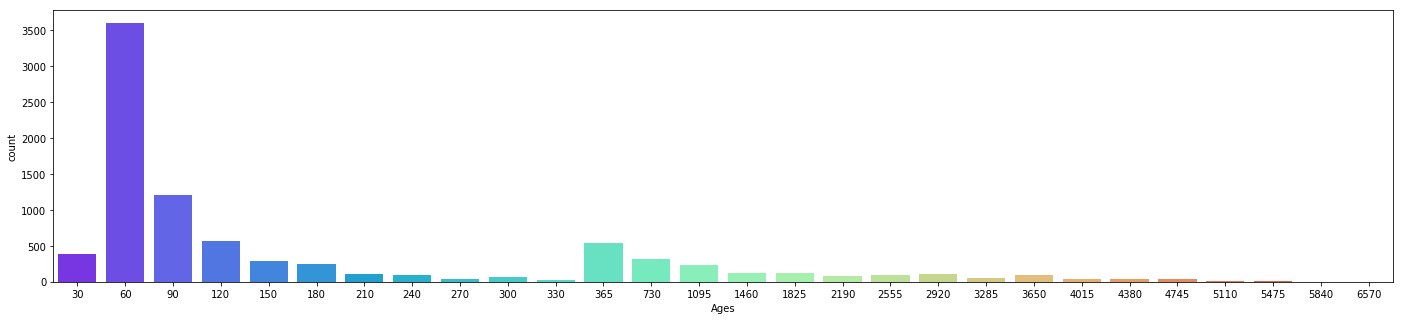

In [32]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==1)], palette='rainbow')

##### c. Perbandingan jumlah kucing yang tidak diadopsi per umur

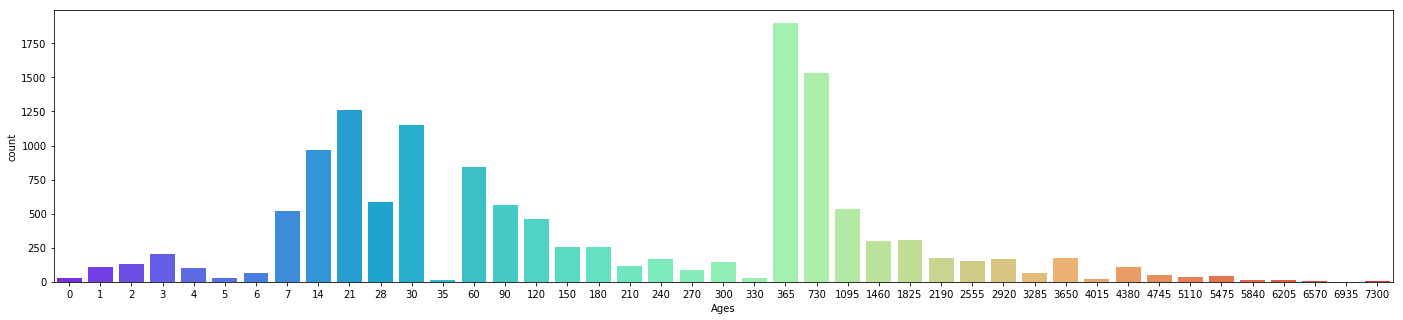

In [33]:
plt.figure(figsize=(24,5))
sns.countplot(x='Ages', data=animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==0)], palette='rainbow')

Kesimpulan:
- Range umur kucing dari umur 0 - 7300 hari
- Umur kucing paling banyak ada di umur 60, 365 dan 730 hari
- Umur kucing yang paling banyak diadopsi: 60, 90 hari
- Umur kucing yang jarang diadopsi: 365, 730 hari

### 8. Warna anjing

##### a. 5 warna anjing terbanyak

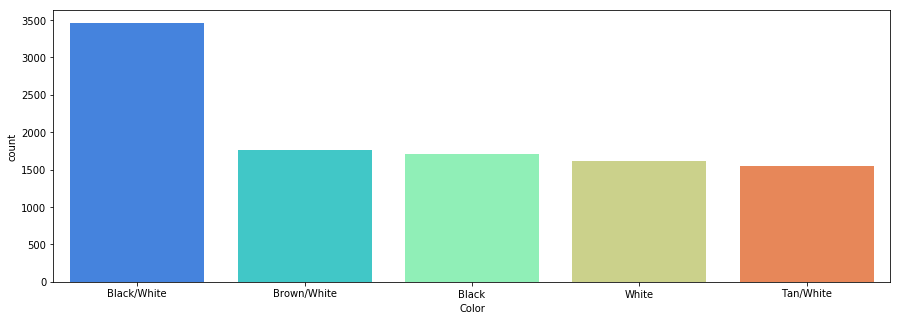

In [34]:
top5 = animalDf[animalDf['AnimalType']=='Dog'].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Dog')], palette='rainbow', order=top5)

##### b. 5 warna anjing yang paling banyak diadopsi

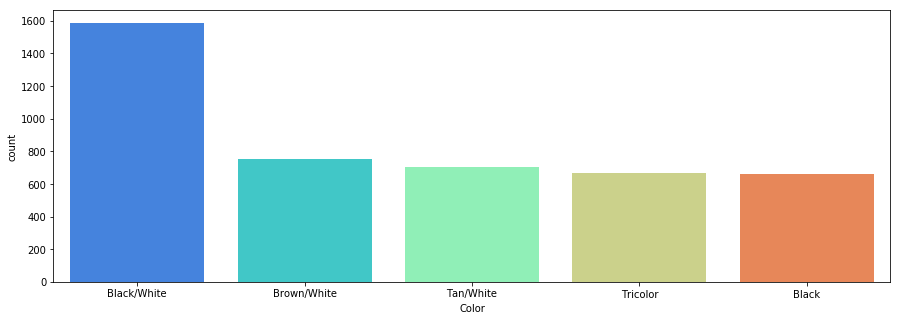

In [35]:
top5 = animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==1)].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Dog') & (animalDf['adoption']==1)], palette='rainbow', order=top5)

##### c. 5 warna anjing yang paling banyak tidak diadopsi

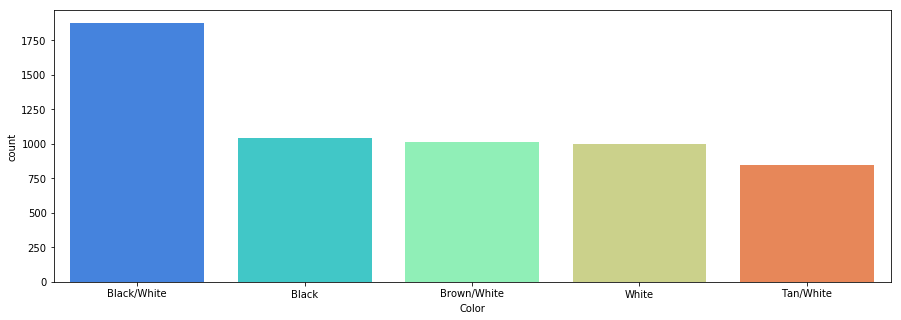

In [36]:
top5 = animalDf[(animalDf['AnimalType']=='Dog') & (animalDf['adoption']==0)].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Dog') & (animalDf['adoption']==0)], palette='rainbow', order=top5)

### 9. Warna kucing

##### a. 5 warna kucing terbanyak

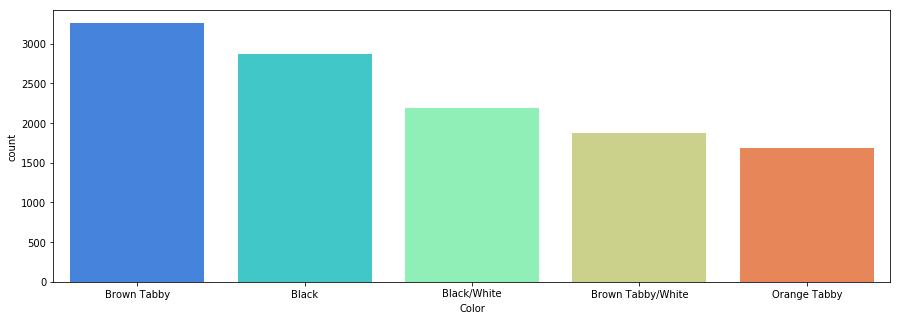

In [37]:
top5 = animalDf[animalDf['AnimalType']=='Cat'].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Cat')], palette='rainbow', order=top5)

##### b. 5 warna kucing yang paling banyak diadopsi

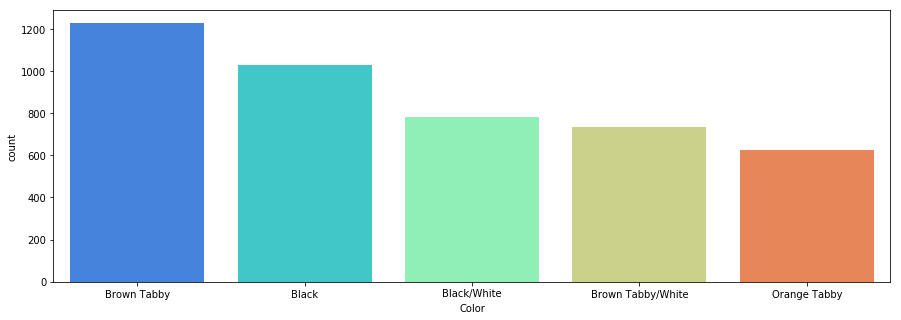

In [38]:
top5 = animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==1)].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Cat') & (animalDf['adoption']==1)], palette='rainbow', order=top5)

##### c. 5 warna kucing yang paling banyak tidak diadopsi

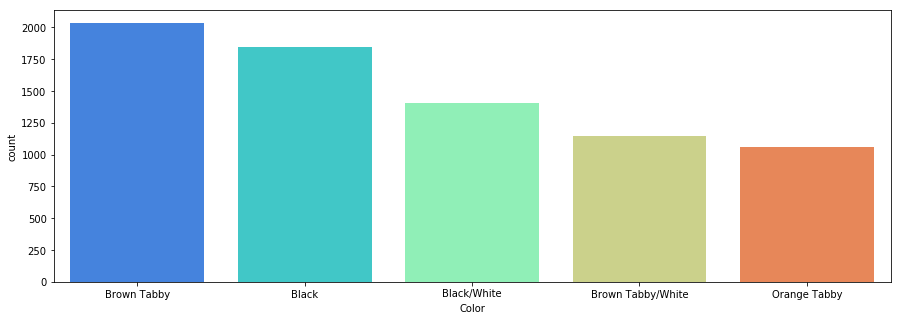

In [39]:
top5 = animalDf[(animalDf['AnimalType']=='Cat') & (animalDf['adoption']==0)].groupby('Color').count().sort_values('Breed',axis=0,ascending=False).head(5).index.values

plt.figure(figsize=(15, 5))
sns.countplot(x='Color', data=animalDf[(animalDf['Color'].isin(top5)) & (animalDf['AnimalType']=='Cat') & (animalDf['adoption']==0)], palette='rainbow', order=top5)

In [40]:
animalDf.head(2)

,DateTime,OutcomeType,AnimalType,SexuponOutcome,Breed,Color,adoption,month,Ages
0,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,0,2,365
1,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,0,10,365


## Feature Engineering

In [41]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [42]:
leSex = le.fit_transform(animalDf['SexuponOutcome'])

animalDf.drop(['SexuponOutcome'],axis=1,inplace=True)
animalDf['nSex'] = leSex

In [43]:
AnimalType = pd.get_dummies(animalDf['AnimalType'],drop_first=True)
animalDf.drop(['AnimalType'],axis=1,inplace=True)
animalDf = pd.concat([animalDf,AnimalType],axis=1)

In [44]:
leColor = le.fit_transform(animalDf['Color'])

animalDf.drop(['Color'],axis=1,inplace=True)
animalDf['nColor'] = leColor

In [45]:
leBreed = le.fit_transform(animalDf['Breed'])

animalDf.drop(['Breed'],axis=1,inplace=True)
animalDf['nBreed'] = leBreed

In [46]:
# month = pd.get_dummies(animalDf['month'],drop_first=True)
# animalDf.drop(['month'],axis=1,inplace=True)
# animalDf = pd.concat([animalDf,month],axis=1)

In [47]:
animalDf.head(2)

,DateTime,OutcomeType,adoption,month,Ages,nSex,Dog,nColor,nBreed
0,2014-02-12 18:22:00,Return_to_owner,0,2,365,2,1,130,1221
1,2013-10-13 12:44:00,Euthanasia,0,10,365,3,0,167,640


# Machine Learning

## Train Test Split

In [48]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score

In [49]:
trainDf = animalDf.copy()
trainDf.sort_values(by='DateTime')
trainDf.drop(['OutcomeType', 'DateTime'], axis=1, inplace=True)

In [50]:
X = trainDf.drop(['adoption'], axis=1)
y = trainDf['adoption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Random Over Sampler

In [51]:
pd.Series(y_train).value_counts()

0    22365
1    15029
Name: adoption, dtype: int64

In [52]:
ros = RandomOverSampler(random_state=101)
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [53]:
pd.Series(y_ros).value_counts()

1    22365
0    22365
dtype: int64

## 1. Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

### Train Model

In [55]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_ros, y_ros)
rfc_pred = rfc.predict(X_test)
rfc_predictProba=rfc.predict_proba(X_test)

In [56]:
con = pd.DataFrame(data=confusion_matrix(y_test, rfc_pred), columns=['Prediction No', 'Prediction Yes'], index=['Actual No', 'Actual Yes'])
print(con)
print('\n')

print(classification_report(y_test, rfc_pred))
print('Matthews corrcoef:', matthews_corrcoef(y_test, rfc_pred))
print('ROC Score:', roc_auc_score(y_test, rfc_predictProba[:,1]))
print('Accuracy Score:', accuracy_score(y_test,rfc_pred))

            Prediction No  Prediction Yes
Actual No            8534             983
Actual Yes            833            5676


              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9517
           1       0.85      0.87      0.86      6509

   micro avg       0.89      0.89      0.89     16026
   macro avg       0.88      0.88      0.88     16026
weighted avg       0.89      0.89      0.89     16026

Matthews corrcoef: 0.766088204398988
ROC Score: 0.9484054885539058
Accuracy Score: 0.8866841382753027


In [57]:
rfc_pred_ros = rfc.predict(X_ros)
rfc_predictProba_ros=rfc.predict_proba(X_ros)

In [58]:
con = pd.DataFrame(data=confusion_matrix(y_ros, rfc_pred_ros), columns=['Prediction No', 'Prediction Yes'], index=['Actual No', 'Actual Yes'])
print(con)
print('\n')

print(classification_report(y_ros, rfc_pred_ros))
print('Matthews corrcoef:', matthews_corrcoef(y_ros, rfc_pred_ros))
print('ROC Score:', roc_auc_score(y_ros, rfc_predictProba_ros[:,1]))
print('Accuracy Score:', accuracy_score(y_ros,rfc_pred_ros))

            Prediction No  Prediction Yes
Actual No           21460             905
Actual Yes            420           21945


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22365
           1       0.96      0.98      0.97     22365

   micro avg       0.97      0.97      0.97     44730
   macro avg       0.97      0.97      0.97     44730
weighted avg       0.97      0.97      0.97     44730

Matthews corrcoef: 0.9409769267928133
ROC Score: 0.9964141257610997
Accuracy Score: 0.9703778224904985


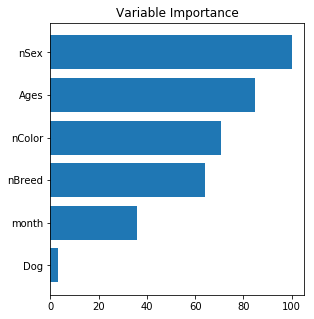

In [59]:
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=[10,5])
plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, X_train.columns.values[sorted_idx])
# plt.xlabel('Realtive Importance')
plt.title('Variable Importance')
plt.show()

## 2. K Nearest Neighbors Classifier

### Train Model

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
knn = KNeighborsClassifier(n_neighbors=35)
knn.fit(X_ros,y_ros)
knn_pred = knn.predict(X_test)
knn_predictProba = knn.predict_proba(X_test)

In [62]:
con = pd.DataFrame(data=confusion_matrix(y_test, knn_pred), columns=['Prediction No', 'Prediction Yes'], index=['Actual No', 'Actual Yes'])
print(con)
print('\n')

print(classification_report(y_test,knn_pred))
print('Matthews Corrcoef:', matthews_corrcoef(y_test, knn_pred))
print('ROC Score:', roc_auc_score(y_test, knn_predictProba[:,1]))
print('Accuracy Score:', accuracy_score(y_test,knn_pred))

            Prediction No  Prediction Yes
Actual No            6223            3294
Actual Yes           1925            4584


              precision    recall  f1-score   support

           0       0.76      0.65      0.70      9517
           1       0.58      0.70      0.64      6509

   micro avg       0.67      0.67      0.67     16026
   macro avg       0.67      0.68      0.67     16026
weighted avg       0.69      0.67      0.68     16026

Matthews Corrcoef: 0.35182304626636385
ROC Score: 0.7592948669467819
Accuracy Score: 0.6743416947460377


### Choosing K Value

In [63]:
error_rate = []

for i in range(20,70,5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_ros,y_ros)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))  

Text(0,0.5,'Error Rate')

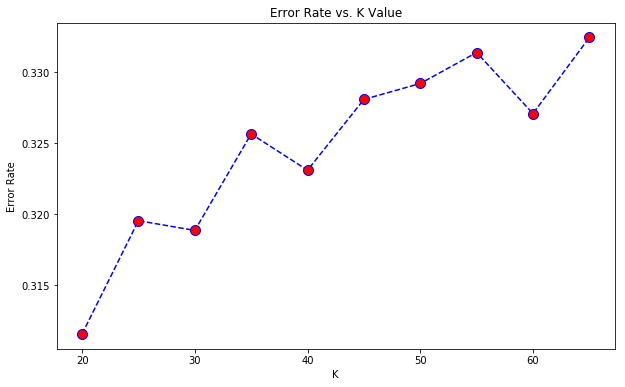

In [64]:
plt.figure(figsize=(10,6))
plt.plot(range(20,70,5),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### Train Model

In [65]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_ros,y_ros)
knn_pred = knn.predict(X_test)
knn_predictProba = knn.predict_proba(X_test)

In [66]:
con = pd.DataFrame(data=confusion_matrix(y_test, knn_pred), columns=['Prediction No', 'Prediction Yes'], index=['Actual No', 'Actual Yes'])
print(con)
print('\n')

print(classification_report(y_test,knn_pred))
print('Matthews Corrcoef:', matthews_corrcoef(y_test, knn_pred))
print('ROC Score:', roc_auc_score(y_test, knn_predictProba[:,1]))
print('Accuracy Score:', accuracy_score(y_test,knn_pred))

            Prediction No  Prediction Yes
Actual No            6621            2896
Actual Yes           2097            4412


              precision    recall  f1-score   support

           0       0.76      0.70      0.73      9517
           1       0.60      0.68      0.64      6509

   micro avg       0.69      0.69      0.69     16026
   macro avg       0.68      0.69      0.68     16026
weighted avg       0.70      0.69      0.69     16026

Matthews Corrcoef: 0.3683227867322797
ROC Score: 0.766746524194973
Accuracy Score: 0.6884437788593536


## 3. XGBoost Classifier

### Create data frame RandomOverSampler

In [67]:
rosDf = pd.DataFrame(columns=X_train.columns, data=X_ros)
rosDf['y_ros'] = y_ros

### Train model

In [68]:
from xgboost import XGBClassifier

In [69]:
xgb = XGBClassifier(random_state=101, n_estimators=100, learning_rate=0.1)
xgb.fit(rosDf.drop('y_ros', axis=1),rosDf['y_ros'])

xgb_pred = xgb.predict(X_test)
xgb_predictProba = xgb.predict_proba(X_test)

In [70]:
con = pd.DataFrame(data=confusion_matrix(y_test, xgb_pred), columns=['Prediction No', 'Prediction Yes'], index=['Actual No', 'Actual Yes'])
print(con)
print('\n')

print(classification_report(y_test, xgb_pred))
print('Matthews Corr_coef:', matthews_corrcoef(y_test, xgb_pred))
print('ROC AUC:', roc_auc_score(y_test, xgb_predictProba[:,1]))
print('Accuracy:', accuracy_score(y_test, xgb_pred))

            Prediction No  Prediction Yes
Actual No            6842            2675
Actual Yes           1321            5188


              precision    recall  f1-score   support

           0       0.84      0.72      0.77      9517
           1       0.66      0.80      0.72      6509

   micro avg       0.75      0.75      0.75     16026
   macro avg       0.75      0.76      0.75     16026
weighted avg       0.77      0.75      0.75     16026

Matthews Corr_coef: 0.5068928655446299
ROC AUC: 0.854183995897211
Accuracy: 0.7506551853238488
